# Interpreting Galaxy Classification
*Looking Inside the Basic & Mini-Xception Models Trained on Galaxy Images*


In [11]:
import warnings
warnings.filterwarnings("ignore")

In [100]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow as tf

## Visualizing Intermediate Convnet Activations
For the base CNN model trained on Galaxy Images

In [13]:
base_model = keras.models.load_model('models/base_galaxy_class_w_aug.keras')
base_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                       

In [14]:
# downloading image of NGC 5728 (barred spiral galaxy) for interpretation
img_path = keras.utils.get_file(fname="interpretation_galaxy_sombrero.jpg",
origin = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/5e/M104_ngc4594_sombrero_galaxy_hi-res.jpg/465px-M104_ngc4594_sombrero_galaxy_hi-res.jpg")

def get_img_array(img_path, target_size):
    """converts image to target sized tensor"""
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(256, 256))

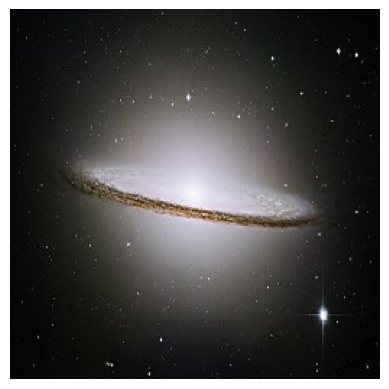

In [15]:
# displaying image
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [16]:
# collecting all convnet and maxpool activations
layer_outputs = []
layer_names = []

for layer in base_model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

# one input -> nine ouputs (form nine conv and maxpool layers, see model summary)
activation_model = keras.Model(inputs=base_model.input, outputs=layer_outputs)

In [17]:
# predicting on fetched image tensor
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 58ms/step


In [18]:
# looking at each activation shape
for name, act in zip(layer_names, activations):
    print(name, " shape: ", act.shape)

conv2d_5  shape:  (1, 254, 254, 32)
max_pooling2d_4  shape:  (1, 127, 127, 32)
conv2d_6  shape:  (1, 125, 125, 64)
max_pooling2d_5  shape:  (1, 62, 62, 64)
conv2d_7  shape:  (1, 60, 60, 128)
max_pooling2d_6  shape:  (1, 30, 30, 128)
conv2d_8  shape:  (1, 28, 28, 256)
max_pooling2d_7  shape:  (1, 14, 14, 256)
conv2d_9  shape:  (1, 12, 12, 256)


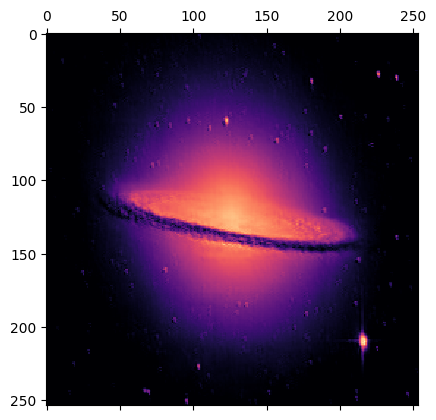

In [89]:
# inspecting a random channel from a random activation
plt.matshow(activations[0][0, :, :, 2], cmap='magma')

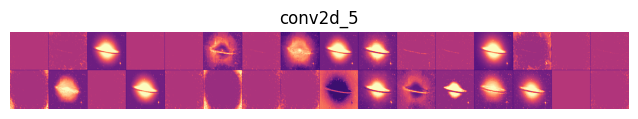

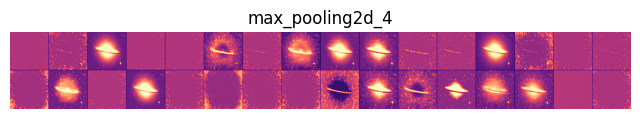

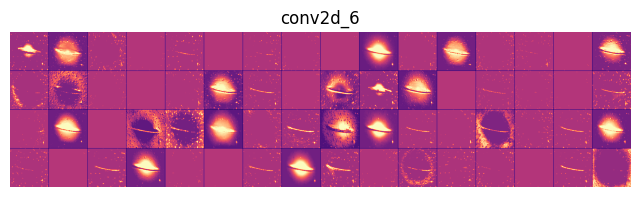

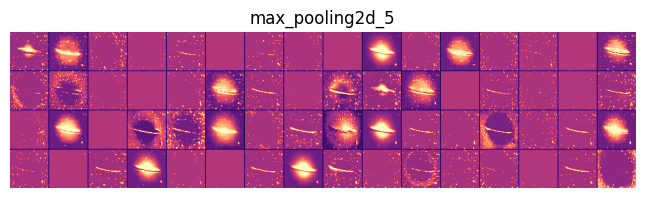

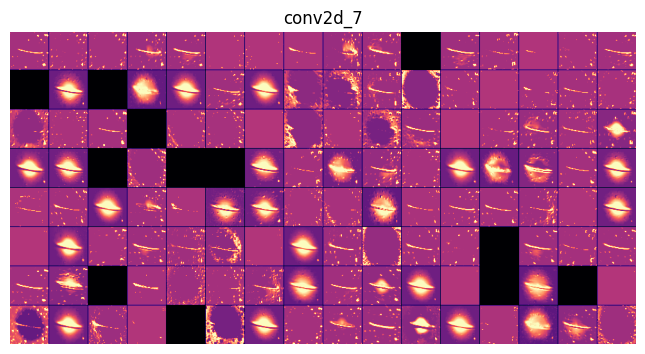

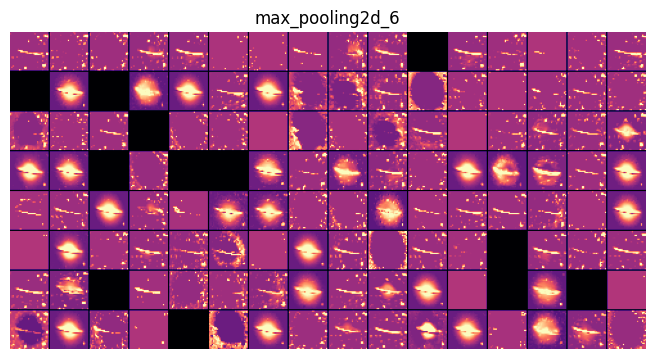

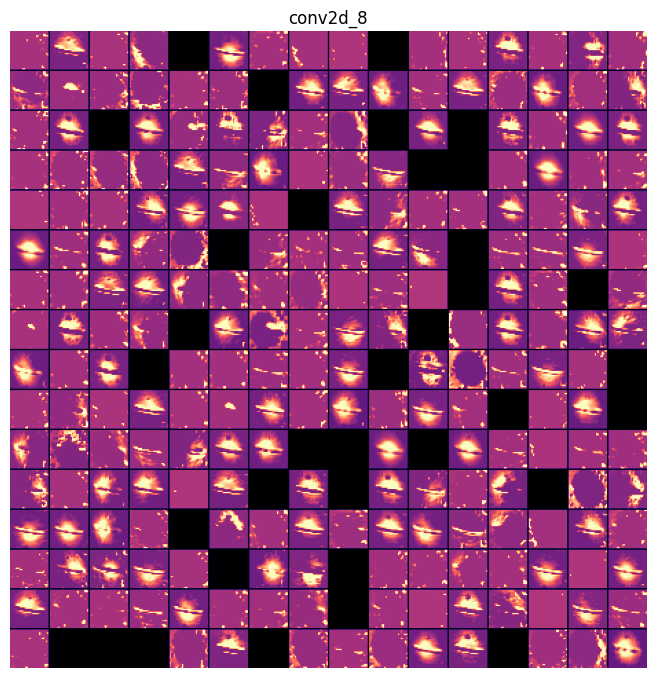

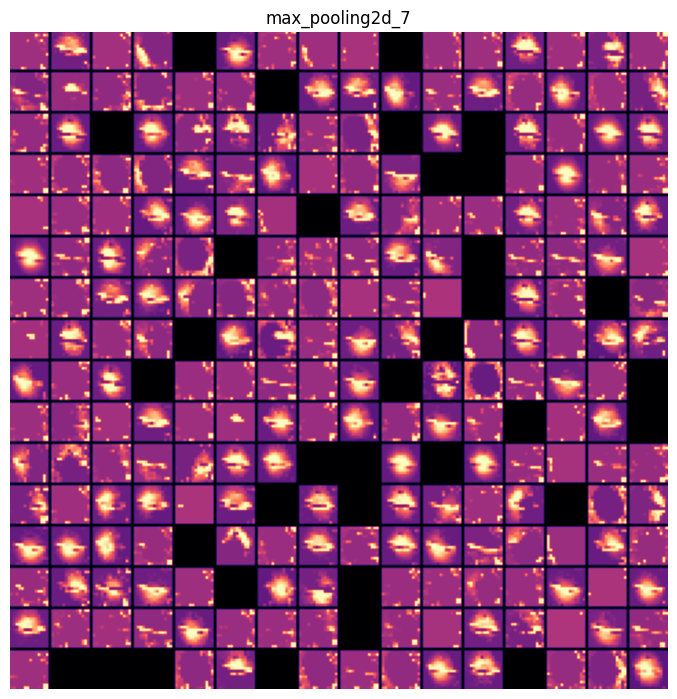

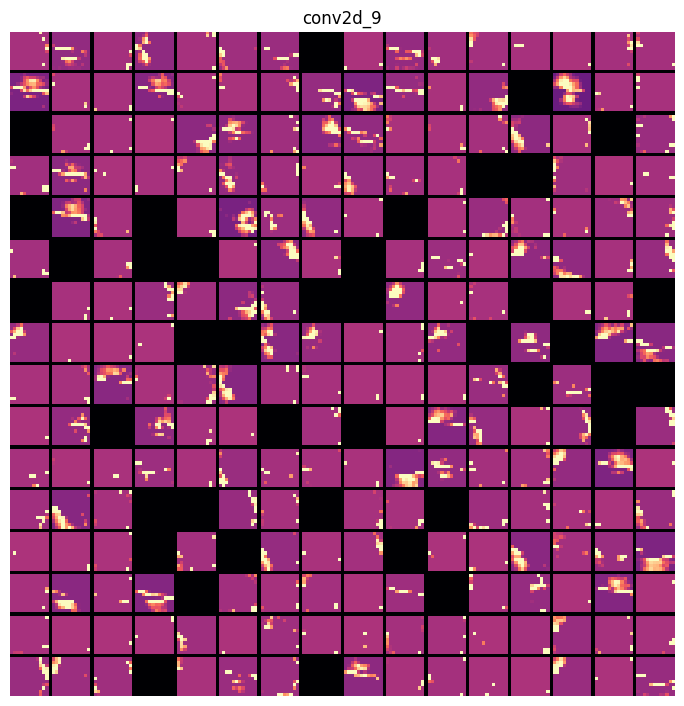

In [95]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                                images_per_row * (size + 1) - 1))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128

            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
        
    scale = 1. / size / (2)
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, cmap="magma")

## Visualizing Convnet Filters
For the Mini-Xception model trained on Galaxy Images

In [96]:
# loading the xception model trained on galaxy images
x_model = keras.models.load_model('models/mini_xception.keras')

# focusing on Conv2D layers and SeperableConv2D layers
for layer in x_model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

conv2d_4
separable_conv2d_2
separable_conv2d_3
conv2d_5
separable_conv2d_4
separable_conv2d_5
conv2d_6
separable_conv2d_6
separable_conv2d_7
conv2d_7
separable_conv2d_8
separable_conv2d_9
conv2d_8
separable_conv2d_10
separable_conv2d_11
conv2d_9


In [123]:
# extracting the feature of particular layer for inspection
layer_name = "conv2d_9"
layer = x_model.get_layer(layer_name)
feature_extractor = keras.Model(inputs=x_model.input, outputs=layer.output)

We now define a loss function that maxmizes the activation of a particular feature map. It's gradient 'ascent' in some sense.

In [124]:
def compute_loss(image, filter_index):
    """computes the loss between an image and feature map"""
    
    # no .predict to compute gradients later
    activation = feature_extractor(image)
    
    # avoid border artifacts (first two and last two pixels)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    
    # returning the average activation
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    """gradient ascent step towards image with high activation"""
    
    # track and find gradients between image and filter
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    
    # normalize gradient so magnitude doesn't scale
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    
    return image

Now we perform gradient ascent for each filter/feature map of interest.

In [125]:
# specify dimensions of output image
img_width = 256
img_height = 256

def generate_filter_pattern(filter_index):
    """gradient ascent for maximal feature map activation"""
    
    # number of iterations/steps for gradient ascent
    iterations = 30
    learning_rate = 10.
    
    # starting image (random noisy image)
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    
    # gradient ascent
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    
    return image[0].numpy()

The resulting image is a floating-point array of shape (200, 200, 3) with rgb values that may not be integers, when they must be. So we do a conversion with the following function.

In [129]:
def deprocess_image(image, crop):
    """processes output image from gradient ascent"""
    
    # normalization
    image -= image.mean()
    image /= image.std()
    
    # increase brightness and center rgb values
    image *= 64
    image += 128
    
    # clip between valid rgb values and crop border artifacts
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[crop:-crop, crop:-crop, :]
    
    return image

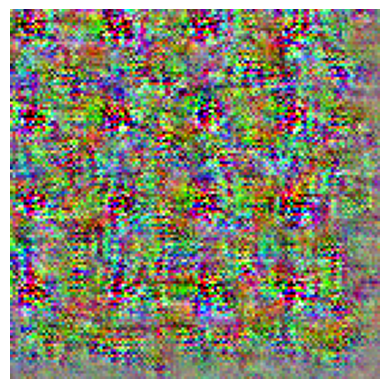

In [131]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=10), 60))